In [1]:
import pandas as pd
import urllib3,certifi
import matplotlib.pyplot as plt

#### Data load from Naver finances

In [2]:
import urllib.parse
import pandas as pd

In [3]:
MARKET_CODE_DICT = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt',
    'konex': 'konexMkt'
}

DOWNLOAD_URL = 'kind.krx.co.kr/corpgeneral/corpList.do'

def download_stock_codes(market=None, delisted=False):
    params = {'method': 'download'}

    if market.lower() in MARKET_CODE_DICT:
        params['marketType'] = MARKET_CODE_DICT[market]

    if not delisted:
        params['searchType'] = 13

    params_string = urllib.parse.urlencode(params)
    request_url = urllib.parse.urlunsplit(['http', DOWNLOAD_URL, '', params_string, ''])

    df = pd.read_html(request_url, header=0)[0]
    df.종목코드 = df.종목코드.map('{:06d}'.format)

    return df

In [4]:
kospi_code_df = download_stock_codes('kospi')

In [5]:
kospi_code_df.shape

(787, 9)

In [6]:
kospi_code_df.head()

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,CJ,001040,기타 금융업,지주회사,1973-06-29,12월,"손경식, 이재현, 이채욱",http://www.cj.net,서울특별시
1,HDC,012630,건물 건설업,"토목공사,건축공사,아파트분양사업,재개발/재건축사업",1996-10-16,12월,정몽규,http://www.i-park.com,서울특별시
2,HSD엔진,082740,일반 목적용 기계 제조업,"대형선박용엔진,내연발전엔진",2011-01-04,12월,고영열,http://www.doosanengine.com,경상남도
3,KG케미칼,001390,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제",1989-08-25,12월,김경묵,http://www.kgchem.co.kr,울산광역시
4,LG이노텍,011070,전자부품 제조업,기타 전자부품 제조업,2008-07-24,12월,박종석,http://www.lginnotek.co.kr,서울특별시


In [7]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다.
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

In [8]:
code_df.head(3)

,name,code
0,CJ,001040
1,HDC,012630
2,HSD엔진,082740


In [9]:
code_df.shape

(2220, 2)

In [10]:
def get_code (item_name, code_df=code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    return code

In [11]:
get_code('카카오')

'035720'

In [12]:
# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    url = 'https://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)

    return url

def get_stock_data(item_name, code_df = code_df, n_pages=20):
    url = get_url(item_name, code_df)

    #Force certificate check and use certifi to handle the certificate. 
    https = urllib3.PoolManager( cert_reqs='CERT_REQUIRED',
    ca_certs=certifi.where(),)  

    # 일자 데이터를 담을 df라는 DataFrame 정의
    df = pd.DataFrame()

    # 1페이지에서 20페이지의 데이터만 가져오기
    for page in range(1, n_pages + 1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        #print('url: ', pg_url)
        https_url = https.urlopen('GET', pg_url) #' https://naver.com')  
        df = df.append(pd.read_html(https_url.data, header=0)[0], ignore_index=True)

    # df.dropna()를 이용해 결측값 있는 행 제거
    df = df.dropna()
    return df

In [13]:
#code_df
get_code('카카오')

'035720'

In [14]:
TOT_PAGES = 40

In [15]:
close_df = pd.DataFrame()

In [16]:
for row in kospi_code_df.iterrows():
    tmpdf = get_stock_data(row[1][0], n_pages=TOT_PAGES)
    close_df[row[1][0]] = tmpdf['종가']
    del tmpdf
    print(row[1][0])

CJ
HDC
HSD엔진
KG케미칼
LG이노텍
SH에너지화학
SK네트웍스
STX
STX중공업
WISCOM
갤럭시아에스엠
경동도시가스
고려제강
골든브릿지증권
극동유화
금호에이치티
까뮤이앤씨
노루페인트
녹십자홀딩스
대덕GDS
대림씨엔에스
대영포장
대원제약
대유에이텍
동국실업
동남합성
동방
동아쏘시오홀딩스
동양
롯데손해보험
롯데하이마트
모두투어리츠
무림페이퍼
무학
미래에셋생명
삼성SDI
삼성바이오로직스
삼성출판사
삼성카드
삼성화재해상보험
삼영전자공업
삼영화학공업
삼진제약
선도전기
선진
세원셀론텍
세이브존I&C
신풍제약
신한알파리츠
신한지주
아시아나항공
아이에스동서
영화금속
오리온
우진
웅진에너지
원림
윌비스
유나이티드
유니온머티리얼
이리츠코크렙
인지컨트롤스
일동제약
제이에스코퍼레이션
제이준코스메틱
제일약품
제일연마
제일파마홀딩스
조일알미늄
조흥
진도
케이씨
코리아써키트
코스맥스
코오롱플라스틱
코웨이
키다리스튜디오
태광산업
태양금속공업
포스코
한국주철관공업
한국철강
한국토지신탁
한국패러랠
한미약품
한솔테크닉스
한일시멘트
한일철강
한진
한창제지
한화갤러리아타임월드
현대건설기계
현대비앤지스틸
현대중공업
호전실업
호텔신라
BGF
CS홀딩스
GKL
GS건설
GS글로벌
JW중외제약
KB금융
KR모터스
LG디스플레이
OCI
S&T모티브
SBS미디어홀딩스
SG충방
SK
SKC
경동인베스트
경보제약
광주은행
금강공업
깨끗한나라
남성
넷마블
대구백화점
대림통상
대양금속
대우건설
대유플러스
대한방직
대한전선
대한제강
대현
동방아그로
동북아12호선박투자
동성코퍼레이션
동양생명
동원금속
두산인프라코어
두올
디씨엠
롯데케미칼
미원에스씨
미원홀딩스
백산
범양건영
보락
보령제약
보해양조
빙그레
사조대림
사조동아원
사조씨푸드
삼양사
삼양식품
삼원강재
삼호
삼화전자공업
서원
성지건설
세방전지
송원산업
신영와코루
써니전자
아모레퍼시픽그룹
아이마켓코리아
아이에이치큐
에이블씨엔씨
엔씨소프트
엔케이
영보화학
영원무역
영진약품
영풍
웅진
유성기업
유한양행
이수화학
이스타코
인디에프
일정실업
조선선재
종근당


In [17]:
close_df.head()

,CJ,HDC,HSD엔진,KG케미칼,LG이노텍,SH에너지화학,SK네트웍스,STX,STX중공업,WISCOM,...,한창,현대로템,현대모비스,현대미포조선,현대약품,현대종합상사,현대중공업지주,효성,휠라코리아,흥국화재
1,132000.0,24500.0,3780.0,27200.0,143500.0,1295.0,4480.0,18050.0,4415.0,3150.0,...,1810.0,27250.0,224000.0,97800.0,5470.0,28700.0,377500.0,45900.0,41750.0,6000.0
2,132500.0,24650.0,3890.0,26600.0,145000.0,1290.0,4525.0,18850.0,4400.0,3155.0,...,1795.0,27050.0,223000.0,98000.0,5410.0,28650.0,387000.0,45100.0,41400.0,6000.0
3,135500.0,24550.0,3785.0,26200.0,145000.0,1280.0,4495.0,18150.0,4380.0,3190.0,...,1790.0,26750.0,226500.0,99900.0,5530.0,28150.0,386500.0,42650.0,41400.0,6010.0
4,135000.0,25050.0,3720.0,26400.0,143000.0,1290.0,4535.0,17850.0,4395.0,3210.0,...,1820.0,26900.0,231000.0,99300.0,5660.0,28150.0,377500.0,42600.0,41550.0,6040.0
5,135000.0,23750.0,3640.0,27100.0,142000.0,1300.0,4440.0,18100.0,4395.0,3200.0,...,1815.0,27450.0,230000.0,94500.0,5520.0,28600.0,373000.0,41250.0,42000.0,6050.0


In [18]:
close_corr = close_df.corr()

In [25]:
close_corr_09 = close_corr[(close_corr > 0.9) & (close_corr < 1.0) ]

In [37]:
x = close_corr_09['KG케미칼'].dropna()
x = pd.DataFrame(x)
x['rel'] = 'KG케미칼'

In [38]:
x

,KG케미칼,rel
STX,0.904067,KG케미칼
제이준코스메틱,0.913631,KG케미칼
호텔신라,0.919578,KG케미칼
코스모화학,0.902746,KG케미칼
대웅제약,0.948685,KG케미칼
셀트리온,0.913290,KG케미칼
태영건설,0.908918,KG케미칼
메타랩스,0.915695,KG케미칼
덴티움,0.923324,KG케미칼


In [39]:
y = pd.concat([x, x])

In [48]:
close_corr_09_companies = pd.DataFrame()
for c in close_corr_09.columns:
    x = close_corr_09[c].dropna()
    if 0 != x.shape[0]:
        x = pd.DataFrame(x)
        x['rel'] = c
        x.columns = ['corr', 'rel']
        close_corr_09_companies = pd.concat([close_corr_09_companies, x], axis=0)
        
        print(x)

             corr    rel
STX      0.904067  KG케미칼
제이준코스메틱  0.913631  KG케미칼
호텔신라     0.919578  KG케미칼
코스모화학    0.902746  KG케미칼
대웅제약     0.948685  KG케미칼
셀트리온     0.913290  KG케미칼
태영건설     0.908918  KG케미칼
메타랩스     0.915695  KG케미칼
덴티움      0.923324  KG케미칼
            corr     rel
세원정공    0.901326  SK네트웍스
한샘      0.927922  SK네트웍스
한국단자공업  0.915067  SK네트웍스
               corr  rel
KG케미칼      0.904067  STX
제이준코스메틱    0.925790  STX
삼양식품       0.907752  STX
삼화전자공업     0.906995  STX
대웅제약       0.922272  STX
시디즈        0.929170  STX
폴루스바이오팜    0.933100  STX
롯데정밀화학     0.902944  STX
셀트리온       0.909259  STX
에이프로젠 KIC  0.915376  STX
한올바이오파마    0.940554  STX
             corr     rel
LG디스플레이  0.917377  WISCOM
삼정펄프     0.930800  WISCOM
코오롱      0.901116  WISCOM
한국자산신탁   0.932853  WISCOM
디아이씨     0.911611  WISCOM
세원정공     0.900296  WISCOM
S&T홀딩스   0.909297  WISCOM
한세엠케이    0.918809  WISCOM
동양고속     0.941689  WISCOM
한국단자공업   0.901184  WISCOM
넥센       0.934009  WISCOM
새론오토모티브  0.910081  WISCOM
세아특수강    0.9

              corr   rel
대유에이텍     0.908894  호전실업
동국실업      0.935289  호전실업
윌비스       0.908752  호전실업
동양생명      0.927335  호전실업
진원생명과학    0.948525  호전실업
쌍방울       0.906463  호전실업
진양화학      0.914887  호전실업
미래아이앤지    0.903092  호전실업
모나미       0.954442  호전실업
쌍용자동차     0.914976  호전실업
크라운해태홀딩스  0.938017  호전실업
두산중공업     0.928000  호전실업
선창산업      0.913967  호전실업
세하        0.912138  호전실업
엘브이엠씨     0.900146  호전실업
주연테크      0.921280  호전실업
진양산업      0.903016  호전실업
DRB동일     0.928952  호전실업
금호전기      0.926752  호전실업
인팩        0.964141  호전실업
한솔피엔에스    0.910337  호전실업
            corr   rel
KG케미칼   0.919578  호텔신라
대웅제약    0.933121  호텔신라
롯데관광개발  0.947507  호텔신라
메타랩스    0.924614  호텔신라
LS산전    0.903750  호텔신라
아세아시멘트  0.912317  호텔신라
LG생활건강  0.955348  호텔신라
덴티움     0.909741  호텔신라
신세계     0.951371  호텔신라
               corr  rel
모두투어리츠     0.934042  BGF
범양건영       0.963859  BGF
일정실업       0.934463  BGF
현대상선       0.922839  BGF
삼성중공업      0.904540  BGF
한솔홀딩스      0.933515  BGF
한화에어로스페이스  0.903842  BGF
LIG넥스원     0.910255 

           corr    rel
엘브이엠씨  0.936042  한전KPS
               corr     rel
모두투어리츠     0.906556  해태제과식품
무학         0.963701  해태제과식품
삼영화학공업     0.923099  해태제과식품
아이에스동서     0.910755  해태제과식품
금강공업       0.917416  해태제과식품
대림통상       0.924130  해태제과식품
삼원강재       0.913999  해태제과식품
아이마켓코리아    0.933829  해태제과식품
유성기업       0.933354  해태제과식품
MH에탄올      0.925601  해태제과식품
미원화학       0.922400  해태제과식품
삼양통상       0.911018  해태제과식품
한화에어로스페이스  0.924494  해태제과식품
LG하우시스     0.923377  해태제과식품
대림비앤코      0.942368  해태제과식품
서연         0.952443  해태제과식품
세원정공       0.923228  해태제과식품
S&T중공업     0.915113  해태제과식품
비상교육       0.907049  해태제과식품
엔피씨        0.908059  해태제과식품
진양홀딩스      0.901856  해태제과식품
KC그린홀딩스    0.921664  해태제과식품
선창산업       0.910510  해태제과식품
LG상사       0.916266  해태제과식품
케이티스       0.906428  해태제과식품
하이트진로홀딩스   0.920251  해태제과식품
BYC        0.943743  해태제과식품
대성홀딩스      0.908844  해태제과식품
서연이화       0.942156  해태제과식품
에스제이엠      0.953527  해태제과식품
에스제이엠홀딩스   0.930273  해태제과식품
키위미디어그룹    0.902053  해태제과식품
               corr   rel
모두투어

             corr    rel
세이브존I&C  0.924795  한라홀딩스
한솔테크닉스   0.936082  한라홀딩스
동원금속     0.903595  한라홀딩스
이수화학     0.920454  한라홀딩스
한국자산신탁   0.921792  한라홀딩스
강원랜드     0.912179  한라홀딩스
SK디스커버리  0.902926  한라홀딩스
한세엠케이    0.942475  한라홀딩스
동양고속     0.949196  한라홀딩스
한국단자공업   0.930822  한라홀딩스
새론오토모티브  0.931762  한라홀딩스
세아특수강    0.912735  한라홀딩스
현대위아     0.930077  한라홀딩스
               corr    rel
BGF        0.933515  한솔홀딩스
범양건영       0.905920  한솔홀딩스
현대상선       0.930207  한솔홀딩스
롯데지주       0.914676  한솔홀딩스
HDC아이콘트롤스  0.946033  한솔홀딩스
한국제지       0.907366  한솔홀딩스
현대일렉트릭     0.931449  한솔홀딩스
             corr     rel
메리츠종금증권  0.909517  한신기계공업
              corr        rel
고려제강      0.900455  한화에어로스페이스
모두투어리츠    0.917105  한화에어로스페이스
무학        0.924102  한화에어로스페이스
삼영화학공업    0.917086  한화에어로스페이스
아이에스동서    0.904767  한화에어로스페이스
제일파마홀딩스   0.900014  한화에어로스페이스
BGF       0.903842  한화에어로스페이스
대구백화점     0.914181  한화에어로스페이스
대림통상      0.917173  한화에어로스페이스
동원금속      0.912491  한화에어로스페이스
삼원강재      0.915819  한화에어로스페이스
유성기업      0.959495  한화

          corr     rel
금강공업  0.912895  코오롱글로벌
선창산업  0.906611  코오롱글로벌
에넥스   0.922237  코오롱글로벌
            corr      rel
미원홀딩스   0.933158  코오롱머티리얼
엔에스쇼핑   0.930290  코오롱머티리얼
대웅      0.969680  코오롱머티리얼
화승알앤에이  0.972454  코오롱머티리얼
신풍제지    0.923468  코오롱머티리얼
일성건설    0.946094  코오롱머티리얼
           corr   rel
나노메딕스  0.900282  키움증권
신세계    0.918601  키움증권
             corr   rel
KG케미칼    0.908918  태영건설
삼성전기     0.902127  태영건설
LS산전     0.920738  태영건설
덴티움      0.921407  태영건설
삼화콘덴서공업  0.911169  태영건설
            corr    rel
신세계I&C  0.939915  평화홀딩스
          corr    rel
넥센    0.907968  포스코강판
제주은행  0.912707  포스코강판
           corr   rel
케이씨티시  0.925993  한국주강
             corr rel
다스코      0.951730  한라
동아지질     0.917889  한라
혜인       0.927590  한라
일신석재     0.928141  한라
도화엔지니어링  0.905613  한라
              corr   rel
삼원강재      0.904995  한전산업
진양홀딩스     0.906267  한전산업
에스제이엠홀딩스  0.913907  한전산업
            corr       rel
현대상선    0.915267  한진중공업홀딩스
현대일렉트릭  0.938738  한진중공업홀딩스
           corr rel
풍산홀딩스  0.937584  한화
GS   

               corr    rel
고려제강       0.931725  진양홀딩스
모두투어리츠     0.947701  진양홀딩스
세이브존I&C    0.939742  진양홀딩스
BGF        0.930315  진양홀딩스
대구백화점      0.920774  진양홀딩스
대림통상       0.909775  진양홀딩스
동원금속       0.913946  진양홀딩스
백산         0.903804  진양홀딩스
삼원강재       0.953499  진양홀딩스
유성기업       0.909605  진양홀딩스
일정실업       0.961692  진양홀딩스
해태제과식품     0.901856  진양홀딩스
삼정펄프       0.929567  진양홀딩스
한국자산신탁     0.939213  진양홀딩스
한화에어로스페이스  0.930587  진양홀딩스
LG하우시스     0.929991  진양홀딩스
LIG넥스원     0.936232  진양홀딩스
대동전자       0.933845  진양홀딩스
대림비앤코      0.902506  진양홀딩스
디아이씨       0.922927  진양홀딩스
서연         0.918639  진양홀딩스
세원정공       0.954803  진양홀딩스
한전산업       0.906267  진양홀딩스
S&T홀딩스     0.904830  진양홀딩스
엔피씨        0.936827  진양홀딩스
동양고속       0.917855  진양홀딩스
동일고무벨트     0.938795  진양홀딩스
HDC아이콘트롤스  0.906431  진양홀딩스
넥센         0.915015  진양홀딩스
새론오토모티브    0.907752  진양홀딩스
하이트진로홀딩스   0.946839  진양홀딩스
현대일렉트릭     0.923116  진양홀딩스
BYC        0.947158  진양홀딩스
대성홀딩스      0.934131  진양홀딩스
서연이화       0.916464  진양홀딩스
에스제이엠      0.956083  진양홀딩스
에

           corr     rel
환인제약   0.900074  지엠비코리아
일진다이아  0.936875  지엠비코리아
          corr rel
윌비스   0.900772  지코
모나미   0.914648  지코
진양산업  0.901438  지코
             corr  rel
삼진제약     0.905566  컨버즈
제이준코스메틱  0.919367  컨버즈
파미셀      0.933301  컨버즈
롯데관광개발   0.936213  컨버즈
유양디앤유    0.900567  컨버즈
신대양제지    0.921817  컨버즈
인스코비     0.918361  컨버즈
             corr     rel
SK네트웍스   0.915067  한국단자공업
WISCOM   0.901184  한국단자공업
세이브존I&C  0.926023  한국단자공업
한솔테크닉스   0.926227  한국단자공업
S&T모티브   0.905803  한국단자공업
대구백화점    0.908693  한국단자공업
이수화학     0.921760  한국단자공업
삼정펄프     0.901993  한국단자공업
한국자산신탁   0.905666  한국단자공업
한라홀딩스    0.930822  한국단자공업
세원정공     0.913008  한국단자공업
한세엠케이    0.937350  한국단자공업
동양고속     0.938384  한국단자공업
새론오토모티브  0.938927  한국단자공업
현대위아     0.900928  한국단자공업
         corr    rel
카카오  0.918232  한온시스템
               corr      rel
STX        0.940554  한올바이오파마
삼화전자공업     0.900518  한올바이오파마
대웅제약       0.907128  한올바이오파마
시디즈        0.934398  한올바이오파마
폴루스바이오팜    0.940047  한올바이오파마
롯데정밀화학     0.906175  한올바이오파마
셀트리온   

             corr    rel
고려제강     0.939718  한국쉘석유
세이브존I&C  0.922970  한국쉘석유
대구백화점    0.952462  한국쉘석유
동원금속     0.914223  한국쉘석유
신영와코루    0.911421  한국쉘석유
일정실업     0.929981  한국쉘석유
S&T홀딩스   0.905181  한국쉘석유
미창석유공업   0.920890  한국쉘석유
동양고속     0.904774  한국쉘석유
               corr   rel
고려제강       0.904776  한국제지
대림씨엔에스     0.912858  한국제지
동국실업       0.918289  한국제지
모두투어리츠     0.931039  한국제지
조일알미늄      0.944731  한국제지
BGF        0.904771  한국제지
동양생명       0.939075  한국제지
유성기업       0.921540  한국제지
일정실업       0.905926  한국제지
현대상선       0.920934  한국제지
남영비비안      0.918547  한국제지
진양화학       0.903985  한국제지
한솔홀딩스      0.907366  한국제지
대동전자       0.907595  한국제지
롯데지주       0.926081  한국제지
서연         0.912762  한국제지
CJ씨푸드      0.907753  한국제지
케이티스카이라이프  0.911014  한국제지
크라운해태홀딩스   0.915705  한국제지
화신         0.920171  한국제지
동일고무벨트     0.939495  한국제지
선창산업       0.938255  한국제지
엘브이엠씨      0.900075  한국제지
HDC아이콘트롤스  0.903204  한국제지
SG세계물산     0.914561  한국제지
주연테크       0.919726  한국제지
현대일렉트릭     0.938103  한국제지
흥아해운       0.971721  한

              corr rel
대유에이텍     0.903086  인팩
동국실업      0.949492  인팩
삼영화학공업    0.904496  인팩
윌비스       0.916748  인팩
제일파마홀딩스   0.935780  인팩
조일알미늄     0.916645  인팩
호전실업      0.964141  인팩
동양생명      0.955495  인팩
유성기업      0.914521  인팩
진원생명과학    0.958091  인팩
삼양통상      0.919288  인팩
쌍방울       0.900444  인팩
진양화학      0.939739  인팩
금비        0.910446  인팩
서연        0.912005  인팩
모나미       0.929451  인팩
쌍용자동차     0.935422  인팩
크라운해태홀딩스  0.934328  인팩
화신        0.919126  인팩
KC그린홀딩스   0.904457  인팩
두산중공업     0.917218  인팩
선창산업      0.929273  인팩
세하        0.928213  인팩
엘브이엠씨     0.911628  인팩
주연테크      0.934920  인팩
진양산업      0.912189  인팩
한국제지      0.927838  인팩
흥아해운      0.921597  인팩
DRB동일     0.953554  인팩
금호전기      0.947007  인팩
서연이화      0.900753  인팩
유엔젤       0.904259  인팩
한솔피엔에스    0.927060  인팩
             corr   rel
미원홀딩스    0.952839  일성건설
국동       0.918188  일성건설
엔에스쇼핑    0.904436  일성건설
코오롱머티리얼  0.946094  일성건설
대웅       0.980001  일성건설
화승알앤에이   0.975547  일성건설
신풍제지     0.927087  일성건설
             corr   rel
WI

In [52]:
maxcorrs = close_corr_09_companies.sort_values('corr', ascending=False)

In [59]:
idx = 0
views = 20

In [67]:
idx += views 
maxidx = maxcorrs.shape[0]
if idx >= maxidx:
    idx = 0
elif (idx + views ) > maxidx:
    idx = maxcorrs.shape[0] - views 
print('idx: ', idx)
maxcorrs.iloc[idx:idx +views]

idx:  160


,corr,rel
쌍용자동차,0.954481,한솔피엔에스
한솔피엔에스,0.954481,쌍용자동차
모나미,0.954442,호전실업
호전실업,0.954442,모나미
한국철강,0.954412,삼성전자
삼성전자,0.954412,한국철강
아세아제지,0.954380,무림P&P
무림P&P,0.954380,아세아제지
현대일렉트릭,0.954125,모두투어리츠
모두투어리츠,0.954125,현대일렉트릭


### 아래는 백업이다.

In [34]:
df_naver = get_stock_data('NAVER', n_pages=TOT_PAGES)

In [35]:
df_kakao = get_stock_data('카카오', n_pages=TOT_PAGES)

In [36]:
df_kakao.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
0,2018.08.17,127000,500,128500,129000,126500,325943
1,2018.08.16,127500,0,124500,128000,124000,478674
2,2018.08.14,127500,3500,125000,128500,123000,518080


In [37]:
df_naver.head(3)

,날짜,종가,전일비,시가,고가,저가,거래량
0,2018.08.17,755000,5000,754000,768000,748000,38765
1,2018.08.16,750000,7000,750000,763000,745000,114099
2,2018.08.14,757000,2000,760000,767000,754000,61603


In [38]:
#df_kakao.info()
#df_naver.info()

In [39]:
import matplotlib.pyplot as plt

In [40]:
df2 = pd.DataFrame()
#df2['date'] = df_naver['날짜']
#df2['naver'] =  df_naver['종가']
df2['naver'] =  df_naver['종가']
df2['kakao'] = df_kakao['종가']

In [41]:
df2['date'] = df_naver['날짜']
df2.date = pd.to_datetime(df2.date)
df2 =df2.set_index('date')

In [42]:
df2 = df2.sort_index()

In [43]:
df2.head(3)

,naver,kakao
date,,
2017-03-14,815000,83500
2017-03-15,820000,82200
2017-03-16,819000,83800


In [44]:
df2['ratio'] = df2['naver'] / df2['kakao']

In [45]:
df2['avg_ratio'] = df2['ratio'].rolling(window=20, min_periods=1).mean()

In [46]:
df2.head(3)

,naver,kakao,ratio,avg_ratio
date,,,,
2017-03-14,815000,83500,9.760479,9.760479
2017-03-15,820000,82200,9.975669,9.868074
2017-03-16,819000,83800,9.773270,9.836473


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


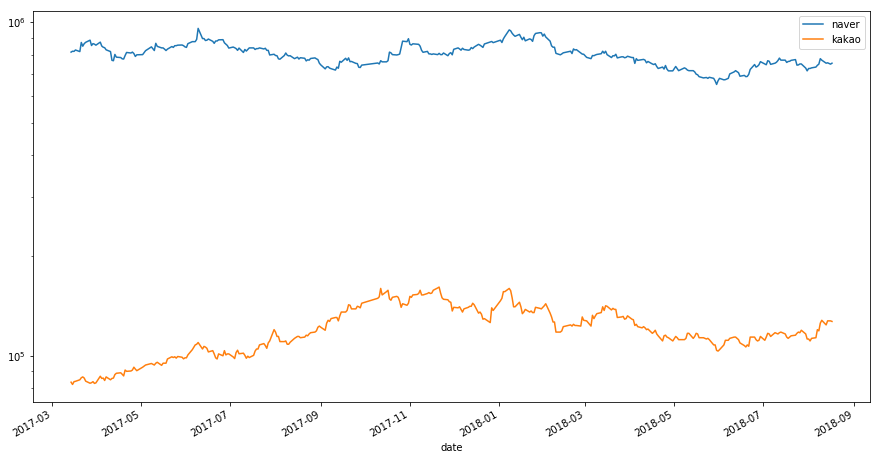

In [47]:
#df2.adropna()
#plt.figure(figsize=(15, 8))
df2.plot(y = ['naver', 'kakao'], logy=True, figsize = (15, 8))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


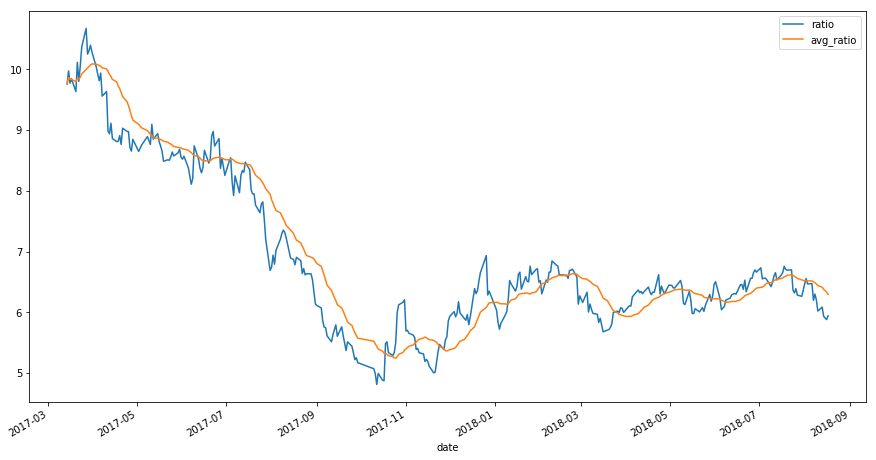

In [48]:
df2.plot(y=['ratio', 'avg_ratio'], figsize = (15, 8))

In [49]:
df2.corr()

,naver,kakao,ratio,avg_ratio
naver,1.000000,0.090383,0.378784,0.299274
kakao,0.090383,1.000000,-0.872087,-0.864318
ratio,0.378784,-0.872087,1.000000,0.963892
avg_ratio,0.299274,-0.864318,0.963892,1.000000


### Normailze data 
Then check correlation

In [50]:
from  sklearn.preprocessing import MinMaxScaler

In [51]:
np_scaled = MinMaxScaler().fit_transform(df2[['naver', 'kakao']])
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head(3)

,0,1
0,0.529221,0.016497
1,0.545455,0.000000
2,0.542208,0.020305


In [52]:
df_normalized.min()

0    0.0
1    0.0
dtype: float64

In [53]:
df_normalized.corr()

,0,1
0,1.000000,0.090383
1,0.090383,1.000000


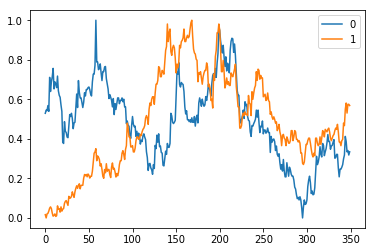

In [56]:
df_normalized.plot()

### 어떤 상관관계가 있다고 보기 애매하다. 

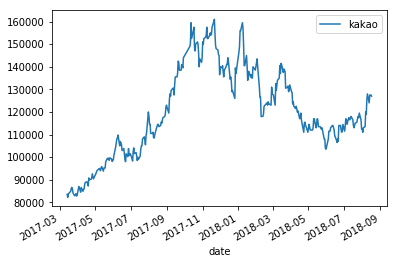

In [54]:
df2.plot(y='kakao')

In [30]:
df2['diff'] = df2['naver'] - df2['kakao']

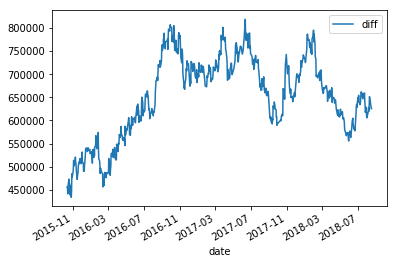

In [31]:
df2.plot(y='diff')